In [1]:
import os
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import numpy as np

os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")

In [2]:
adata = sc.read_h5ad("cluster_files/velocity_anndata_human_fibroblast_DeepCycle_ISMARA.h5ad")

In [3]:
# Rename original scores to preserve them
adata.obs.rename(columns={
    'G2M_score': 'G2M_score_original',
    'S_score': 'S_score_original'
}, inplace=True)

In [4]:
adata

AnnData object with n_obs × n_vars = 5367 × 10789
    obs: 'Clusters', '_X', '_Y', 'sample', 'n_genes', 'percent_mito', 'n_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score_original', 'G2M_score_original', 'phase', 'clusters_gradients', 'leiden', 'cell_cycle_theta'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'gene_count_corr'
    uns: 'ISMARA_activities', 'clusters_gradients_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

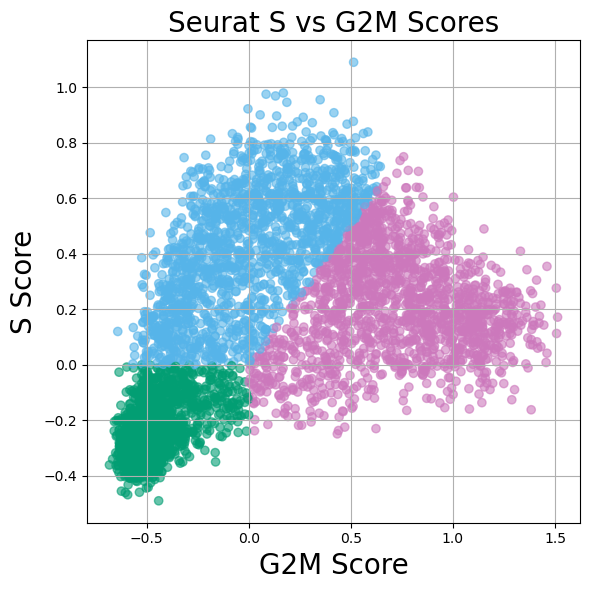

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract phase
phase = adata.obs['phase'].values

# Use specific colors from the colorblind palette
palette = sns.color_palette("colorblind")
selected_colors = [palette[2], palette[4], palette[9]]

# Map phases to colors (ensure consistent ordering)
unique_phases = sorted(np.unique(phase))
colors = {p: c for p, c in zip(unique_phases, selected_colors)}
color_vals = [colors[p] for p in phase]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(
    adata.obs['G2M_score_original'],
    adata.obs['S_score_original'],
    alpha=0.6,
    c=color_vals
)

plt.xlabel('G2M Score', fontsize=20)
plt.ylabel('S Score', fontsize=20)
plt.title('Seurat S vs G2M Scores', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Load as a single column Series
genes = pd.read_csv("cluster_files/regev_lab_cell_cycle_genes.txt", header=None).squeeze()

# First 43 are S phase, rest are G2M
s_genes = genes[:43].tolist()
g2m_genes = genes[43:].tolist()

# Normalize and score cell cycle
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_4195/575835364.py:9: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:588: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


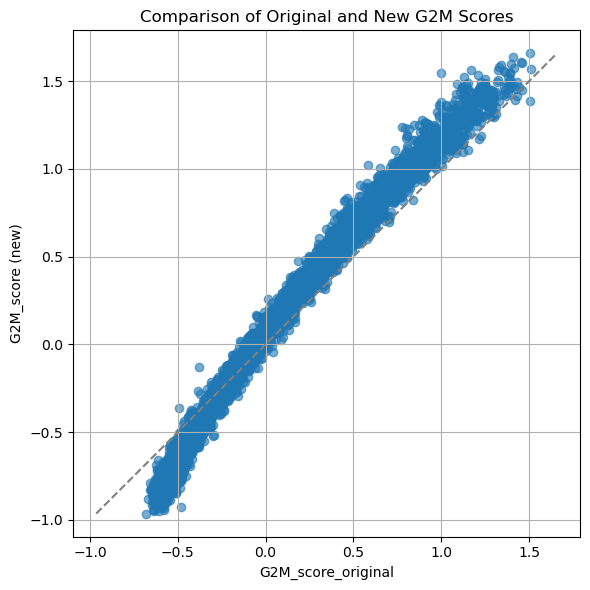

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    adata.obs['G2M_score_original'],
    adata.obs['G2M_score'],
    alpha=0.6
)
plt.xlabel('G2M_score_original')
plt.ylabel('G2M_score (new)')
plt.title('Comparison of Original and New G2M Scores')
plt.grid(True)
plt.tight_layout()
plt.plot([adata.obs['G2M_score'].min(), adata.obs['G2M_score'].max()],
         [adata.obs['G2M_score'].min(), adata.obs['G2M_score'].max()],
         linestyle='--', color='gray')  # identity line
plt.show()


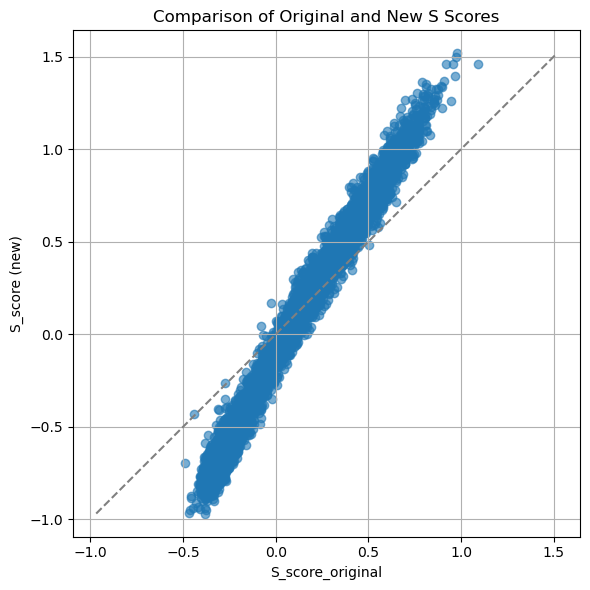

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    adata.obs['S_score_original'],
    adata.obs['S_score'],
    alpha=0.6
)
plt.xlabel('S_score_original')
plt.ylabel('S_score (new)')
plt.title('Comparison of Original and New S Scores')
plt.grid(True)
plt.tight_layout()
plt.plot([adata.obs['S_score'].min(), adata.obs['S_score'].max()],
         [adata.obs['S_score'].min(), adata.obs['S_score'].max()],
         linestyle='--', color='gray')  # identity line
plt.show()


In [21]:
score_angle = np.arctan2(adata.obs["G2M_score"], adata.obs["S_score"])
score_angle = np.mod(score_angle, 2 * np.pi)  # wrap to [0, 2π]

# Store in obs
adata.obs["cycle_angle"] = score_angle

In [23]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

def quantile_to_uniform_2pi(adata, angle_key, output_key):
    # Get input values
    angles = adata.obs[angle_key].values.reshape(-1, 1)

    # Check for NaNs
    if np.isnan(angles).any():
        raise ValueError(f"{angle_key} contains NaNs. Please clean or impute missing values.")

    # Fit and transform on all cells
    qt = QuantileTransformer(
        output_distribution='uniform',
        random_state=0,
        n_quantiles=min(len(angles), 1000),
        subsample=len(angles)
    )
    transformed = qt.fit_transform(angles).flatten()

    # Map to [0, 2π]
    adata.obs[output_key] = transformed * 2 * np.pi


In [24]:
quantile_to_uniform_2pi(
    adata,
    angle_key="cycle_angle",
    output_key="cycle_angle_uniform",
)


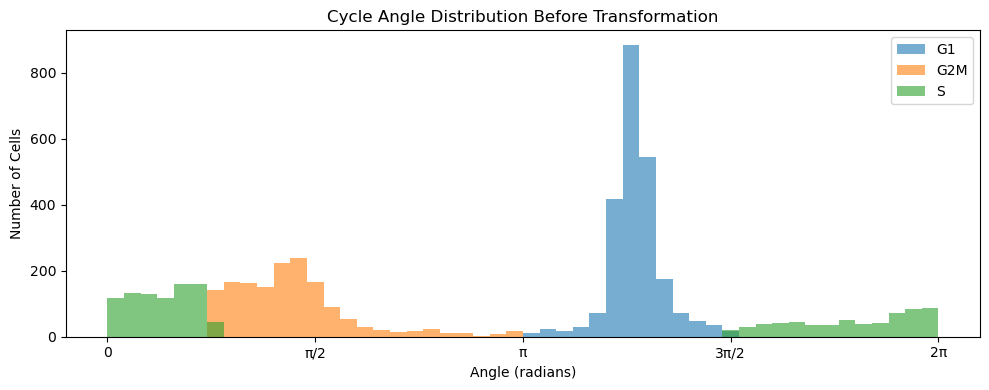

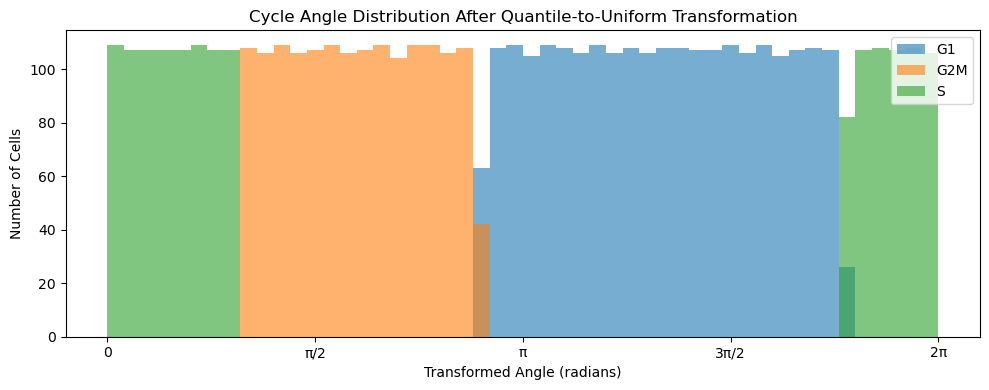

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
n_bins = 50
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
phases = adata.obs["phase"].values
unique_phases = np.unique(phases)
colors = plt.cm.tab10.colors

# Angles
angles_before = np.mod(adata.obs["cycle_angle"].values, 2 * np.pi)
angles_after = np.mod(adata.obs["cycle_angle_uniform"].values, 2 * np.pi)

# --- Plot BEFORE ---
plt.figure(figsize=(10, 4))
for i, phase in enumerate(unique_phases):
    mask = phases == phase
    plt.hist(
        angles_before[mask],
        bins=bin_edges,
        color=colors[i % len(colors)],
        alpha=0.6,
        label=phase
    )

plt.title("Cycle Angle Distribution Before Transformation")
plt.xlabel("Angle (radians)")
plt.ylabel("Number of Cells")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot AFTER ---
plt.figure(figsize=(10, 4))
for i, phase in enumerate(unique_phases):
    mask = phases == phase
    plt.hist(
        angles_after[mask],
        bins=bin_edges,
        color=colors[i % len(colors)],
        alpha=0.6,
        label=phase
    )

plt.title("Cycle Angle Distribution After Quantile-to-Uniform Transformation")
plt.xlabel("Transformed Angle (radians)")
plt.ylabel("Number of Cells")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend()
plt.tight_layout()
plt.show()



In [26]:
adata.write("cluster_files/deepcycle_data_cycle_angle.h5ad")

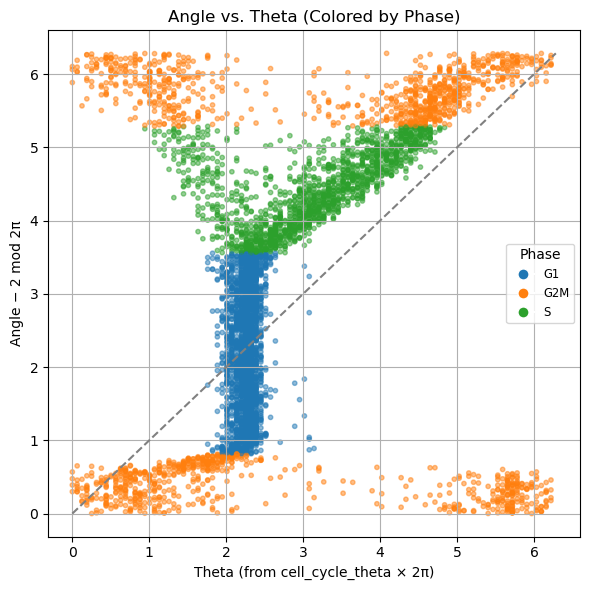

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Extract and transform values
theta = 2 * np.pi * adata.obs['cell_cycle_theta'].values
angle = np.mod(adata.obs['cycle_angle_uniform'].values - 2.0, 2 * np.pi)
phase = adata.obs['phase'].values  # e.g., 'G1', 'S', 'G2M'

# Create color map
unique_phases = np.unique(phase)
colors = {p: c for p, c in zip(unique_phases, plt.cm.tab10.colors[:len(unique_phases)])}
color_vals = [colors[p] for p in phase]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(theta, angle, c=color_vals, alpha=0.5, s=10, label=None)
plt.plot([0, 2 * np.pi], [0, 2 * np.pi], linestyle='--', color='gray', label='y = x')
plt.xlabel('Theta (from cell_cycle_theta × 2π)')
plt.ylabel('Angle − 2 mod 2π')
plt.title('Angle vs. Theta (Colored by Phase)')
plt.grid(True)

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[p], markersize=8, label=p) for p in unique_phases]
plt.legend(handles=handles, title='Phase', fontsize='small')

plt.tight_layout()
plt.show()
